In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [435]:
''' read csv '''
df = pd.read_excel('dataset.xlsx')
print("\033[1mData shape befor filtering:  \033[0m ", df.shape)
print("\033[1mColumns Before renaming: \033[0m")
for c in df.columns:
    print("\t", c)

np.random.seed(2021252) 



''' cleaning: rename '''
df.rename(columns={'Meaning of 2012 NAICS code':'Brand', 'Sales ($1,000)':'Sales'}, inplace=True)

''' filter dataframe '''
df = df[df.Brand=='Retail trade']

''' + columns '''
df['Date'] = np.random.randint(2012,2022,size=(df.shape[0])).tolist()
print("\033[1mData shape after filtering: \033[0m" , df.shape)
for c in df.columns:
    print("\t", c)
''' Drop Columns with only one fix value or repeated columns'''
df = df.drop(['2012 NAICS code', 'Brand', 'Year', 
              'Response coverage of product lines inquiry (%)', 
              'Meaning of Products and services code',
              'Percent of sales accounted for by industry (%)'], axis=1)

''' Replace NAN for empty cells '''
df = df.replace({'X':np.nan, 'Z':np.nan})


''' Replace NAN with mean '''
df = df.fillna(df.mean())












''' Drop High Correlated column (More than 0.95)'''

df = df.drop(['Product line sales as % of total sales of all estabs (%)'], axis=1)

# Sort data by `Date`
df1 = df.sort_values(by = 'Date')
agg_d = {'Number of establishments':'mean', 
         'Total sales of estabs reporting product line ($1,000)':'sum',
         'Product line sales as % of total sales of estabs reporting line (%)':'mean',
         'Sales': 'sum'}
df2 = df1.groupby(['Date'], as_index=False).agg(agg_d)

# Rename Columns to shortnames...
mapper = {'Number of establishments': 'ne', 'Total sales of estabs reporting product line ($1,000)':'tsoerpl',
          'Product line sales as % of total sales of estabs reporting line (%)': 'plsaotsoerl'}
df2 = df2.rename(mapper=mapper, axis=1)

'''
# Reframe dataset to predict next year `Sales` price from current year data
# I could use a window greater than one but I didn't...
# Because I got somehow a good score and there is not much data (we have only 10 instances)...
# I could use upsampling but I think its not what you want..
'''
df10 = df2.copy()
df10 = df10.append(df2.iloc[0]).sort_values(by = 'Date')
df10['dd'] =df10.Date.shift(-1)
df10.dd.iloc[-1]  = 2022
df10['ss'] = df10.Sales.shift(-1)
df10 = df10.drop(['Sales'], axis=1)


# Train Test Split and Data Normalization

split_date = 2017
df3 = df10.copy()
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
mmscaler = preprocessing.MinMaxScaler()#(feature_range=(1,1000))
df_train = df3.loc[df3.Date <= split_date].copy()
df_test = df3.loc[df3.Date  > split_date].copy()
df_train[['ne','tsoerpl','plsaotsoerl']] = pt.fit_transform(df_train[['ne','tsoerpl','plsaotsoerl']])
df_train[['ss']] = mmscaler.fit_transform(df_train[['ss']])

df_test[['ne','tsoerpl','plsaotsoerl']] = pt.transform(df_test[['ne','tsoerpl','plsaotsoerl']])
df_test[['ss']] = mmscaler.transform(df_test[['ss']])

print("Training data is from 2012 to {0}".format(split_date))
print("Test data is from {0} to 2021".format(split_date))

X_train, y_train = df_train[['dd', 'ne','tsoerpl','plsaotsoerl']].values , df_train[['ss']].values
X_test, y_test = df_test[['dd', 'ne','tsoerpl','plsaotsoerl']].values , df_test[['ss']].values




#Training 

import warnings
warnings.filterwarnings("ignore")

params = {
    "n_estimators": 100,
    "max_depth": 1,
    "min_samples_split": 3,
    "learning_rate": 0.9,
    "loss": "ls",
     "random_state": 0
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train.ravel())
rmse = mean_squared_error(y_test.ravel()[:-1], reg.predict(X_test)[:-1], squared=False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
rmse = mean_squared_error(y_train.ravel(), reg.predict(X_train), squared=False)
print("The root mean squared error (RMSE) on train set: {:.4f}".format(rmse))


Data shape befor filtering:    (11797, 12)
Columns Before renaming: 
	 2012 NAICS code
	 Meaning of 2012 NAICS code
	 Products and services code
	 Meaning of Products and services code
	 Year
	 Number of establishments
	 Total sales of estabs reporting product line ($1,000)
	 Sales ($1,000)
	 Product line sales as % of total sales of estabs reporting line (%)
	 Product line sales as % of total sales of all estabs (%)
	 Response coverage of product lines inquiry (%)
	 Percent of sales accounted for by industry (%)
Data shape after filtering:  (51, 13)
	 2012 NAICS code
	 Brand
	 Products and services code
	 Meaning of Products and services code
	 Year
	 Number of establishments
	 Total sales of estabs reporting product line ($1,000)
	 Sales
	 Product line sales as % of total sales of estabs reporting line (%)
	 Product line sales as % of total sales of all estabs (%)
	 Response coverage of product lines inquiry (%)
	 Percent of sales accounted for by industry (%)
	 Date
Training data is

# Fast Fourier Transform: 

FFT is implemented here as an exploratory technique, to see if the stock prices display some harmonics, and which can be used to "lock in" on the price fluctuation. The FFT is applied on the de-trended data (real prices minus the regression), and re-constructed in a similar manner (using the FFT harmonics to construct predictive fluctuation, and then adding the underlying trend - or regression - again to give the total prediction price).

## Exploring Fast Fourier Transform

The whole point of exploring the FFT transform was to investigate whether the price time series has some reliable fluctuation "pattern", that could be used to predict fluctuation. This is done by applying FFT on the de-trended data, and then getting the N strongest FFT frequencies. Then, similar to applying the inverse FFT, we calculate the phase and amplitude of these N frequencies, and use them on the testing period as forecast. We can then add the underlying price, to create the overall prediction.

## FFT By Polynomial Regression Model

During the training period, the underlying trend is provided by the regression trained bellow. Usually, after many trials, the regression of order 3 performs well with the FFT.

During the testing period, we add this to the "Regression" model we trained.

In [436]:
degree = 3
poly = PolynomialFeatures(degree = degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.fit_transform(X_test) 
X_train_test_poly = poly.fit_transform(np.concatenate([X_train, X_test])) 
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [437]:


''' Detrending data '''
# model = LinearRegression()
# model.fit(X_train, y_train)
# df_train['dtrend'] = df_train.ss - reg.predict(X_train)
# df_train['dtrend'] = df_train.ss - model.predict(X_train).ravel()

df_train['dtrend'] = df_train.ss - model.predict(X_train_poly).ravel()



training_end_index = df_train.shape[0]
test_end_index = df3.shape[0]

''' Train FFT '''

fft_pricing_in_freq_domain = np.fft.fft(df_train['dtrend'].values) 
fft_frequencies = np.fft.fftfreq(training_end_index)
highest_freq_amp_indexes = list(range(training_end_index))
highest_freq_amp_indexes.sort(key = lambda x: np.absolute(fft_pricing_in_freq_domain[x]), reverse=True)

fft_x = np.arange(0, test_end_index)
# fft_df = df3.ss.copy()
predictionLr = np.zeros(test_end_index)
waveform = np.zeros(test_end_index)

for freq_i in highest_freq_amp_indexes[:training_end_index//2]:
    fft_power = np.absolute(fft_pricing_in_freq_domain[freq_i]) / df_train.shape[0]  
    fft_phase = np.angle(fft_pricing_in_freq_domain[freq_i]) 
    waveform += fft_power *  np.cos(2 * np.pi * fft_frequencies[freq_i] * fft_x + fft_phase)

# prediction[:df_train.shape[0]] = df_train.ss + waveform[:df_train.shape[0]]
# prediction[df_train.shape[0]:] = df_test.ss + waveform[df_train.shape[0]:]
# prediction  

# train_pred =  reg.predict(X_train)
# test_pred =  reg.predict(X_test)
# prediction[:df_train.shape[0]] = reg.predict(X_train) + waveform[:df_train.shape[0]]
# prediction[df_train.shape[0]:] = reg.predict(X_test) + waveform[df_train.shape[0]:]
# prediction



train_pred =  model.predict(X_train_poly).ravel()
test_pred =  model.predict(X_test_poly).ravel()
predictionLr[:df_train.shape[0]] = train_pred + waveform[:df_train.shape[0]]
predictionLr[df_train.shape[0]:] = test_pred + waveform[df_train.shape[0]:]
predictionLr

rmse = mean_squared_error(y_test.ravel()[:-1], test_pred[:-1] , squared=False)
print("The root mean squared error (RMSE) on test set, Linear Reg Predicted Data: {:.4f}".format(rmse))
rmse = mean_squared_error(y_train.ravel(), train_pred, squared=False)
print("The root mean squared error (RMSE) on train set, Linear Reg Predicted Data: {:.4f}".format(rmse))


rmse = mean_squared_error(y_test.ravel()[:-1], predictionLr[df_train.shape[0]:-1] , squared=False)
print("The root mean squared error (RMSE) on test set, Fourier Predicted Data: {:.4f}".format(rmse))
rmse = mean_squared_error(y_train.ravel(), predictionLr[:df_train.shape[0]], squared=False)
print("The root mean squared error (RMSE) on train set, Fourier Predicted Data: {:.4f}".format(rmse))


The root mean squared error (RMSE) on test set, Linear Reg Predicted Data: 0.2849
The root mean squared error (RMSE) on train set, Linear Reg Predicted Data: 0.2788
The root mean squared error (RMSE) on test set, Fourier Predicted Data: 0.4538
The root mean squared error (RMSE) on train set, Fourier Predicted Data: 0.1400


## FFT By GBR Model

During the training period, the underlying trend is provided by the GradientBoostRegression trained above. 

During the testing period, we add this to the "GradientBoostRegression" model we trained.

In [438]:


''' Detrending data '''


df_train['dtrend'] = df_train.ss - reg.predict(X_train)

training_end_index = df_train.shape[0]
test_end_index = df3.shape[0]

''' Train FFT '''

fft_pricing_in_freq_domain = np.fft.fft(df_train['dtrend'].values) 
fft_frequencies = np.fft.fftfreq(training_end_index)
highest_freq_amp_indexes = list(range(training_end_index))
highest_freq_amp_indexes.sort(key = lambda x: np.absolute(fft_pricing_in_freq_domain[x]), reverse=True)

fft_x = np.arange(0, test_end_index)
predictionGbr = np.zeros(test_end_index)
waveform = np.zeros(test_end_index)

for freq_i in highest_freq_amp_indexes[:training_end_index//2]:
    fft_power = np.absolute(fft_pricing_in_freq_domain[freq_i]) / df_train.shape[0]  
    fft_phase = np.angle(fft_pricing_in_freq_domain[freq_i]) 
    waveform += fft_power *  np.cos(2 * np.pi * fft_frequencies[freq_i] * fft_x + fft_phase)

train_pred =  reg.predict(X_train)
test_pred =  reg.predict(X_test)
predictionGbr[:df_train.shape[0]] = reg.predict(X_train) + waveform[:df_train.shape[0]]
predictionGbr[df_train.shape[0]:] = reg.predict(X_test) + waveform[df_train.shape[0]:]
predictionGbr

rmse = mean_squared_error(y_test.ravel()[:-1], test_pred[:-1] , squared=False)
print("The root mean squared error (RMSE) on test set, Linear Reg Predicted Data: {:.4f}".format(rmse))
rmse = mean_squared_error(y_train.ravel(), train_pred, squared=False)
print("The root mean squared error (RMSE) on train set, Linear Reg Predicted Data: {:.4f}".format(rmse))


rmse = mean_squared_error(y_test.ravel()[:-1], predictionGbr[df_train.shape[0]:-1] , squared=False)
print("The root mean squared error (RMSE) on test set, Fourier Predicted Data: {:.4f}".format(rmse))
rmse = mean_squared_error(y_train.ravel(), predictionGbr[:df_train.shape[0]], squared=False)
print("The root mean squared error (RMSE) on train set, Fourier Predicted Data: {:.4f}".format(rmse))


The root mean squared error (RMSE) on test set, Linear Reg Predicted Data: 0.0131
The root mean squared error (RMSE) on train set, Linear Reg Predicted Data: 0.0000
The root mean squared error (RMSE) on test set, Fourier Predicted Data: 0.0131
The root mean squared error (RMSE) on train set, Fourier Predicted Data: 0.0000


In [439]:
waveform

array([-3.13558025e-11,  1.00244065e-10, -4.74521797e-11,  4.23217626e-11,
       -5.94819832e-11, -3.04474692e-11,  2.61716073e-11, -3.13558025e-11,
        1.00244065e-10, -4.74521797e-11,  4.23217626e-11])

<Figure size 432x288 with 0 Axes>

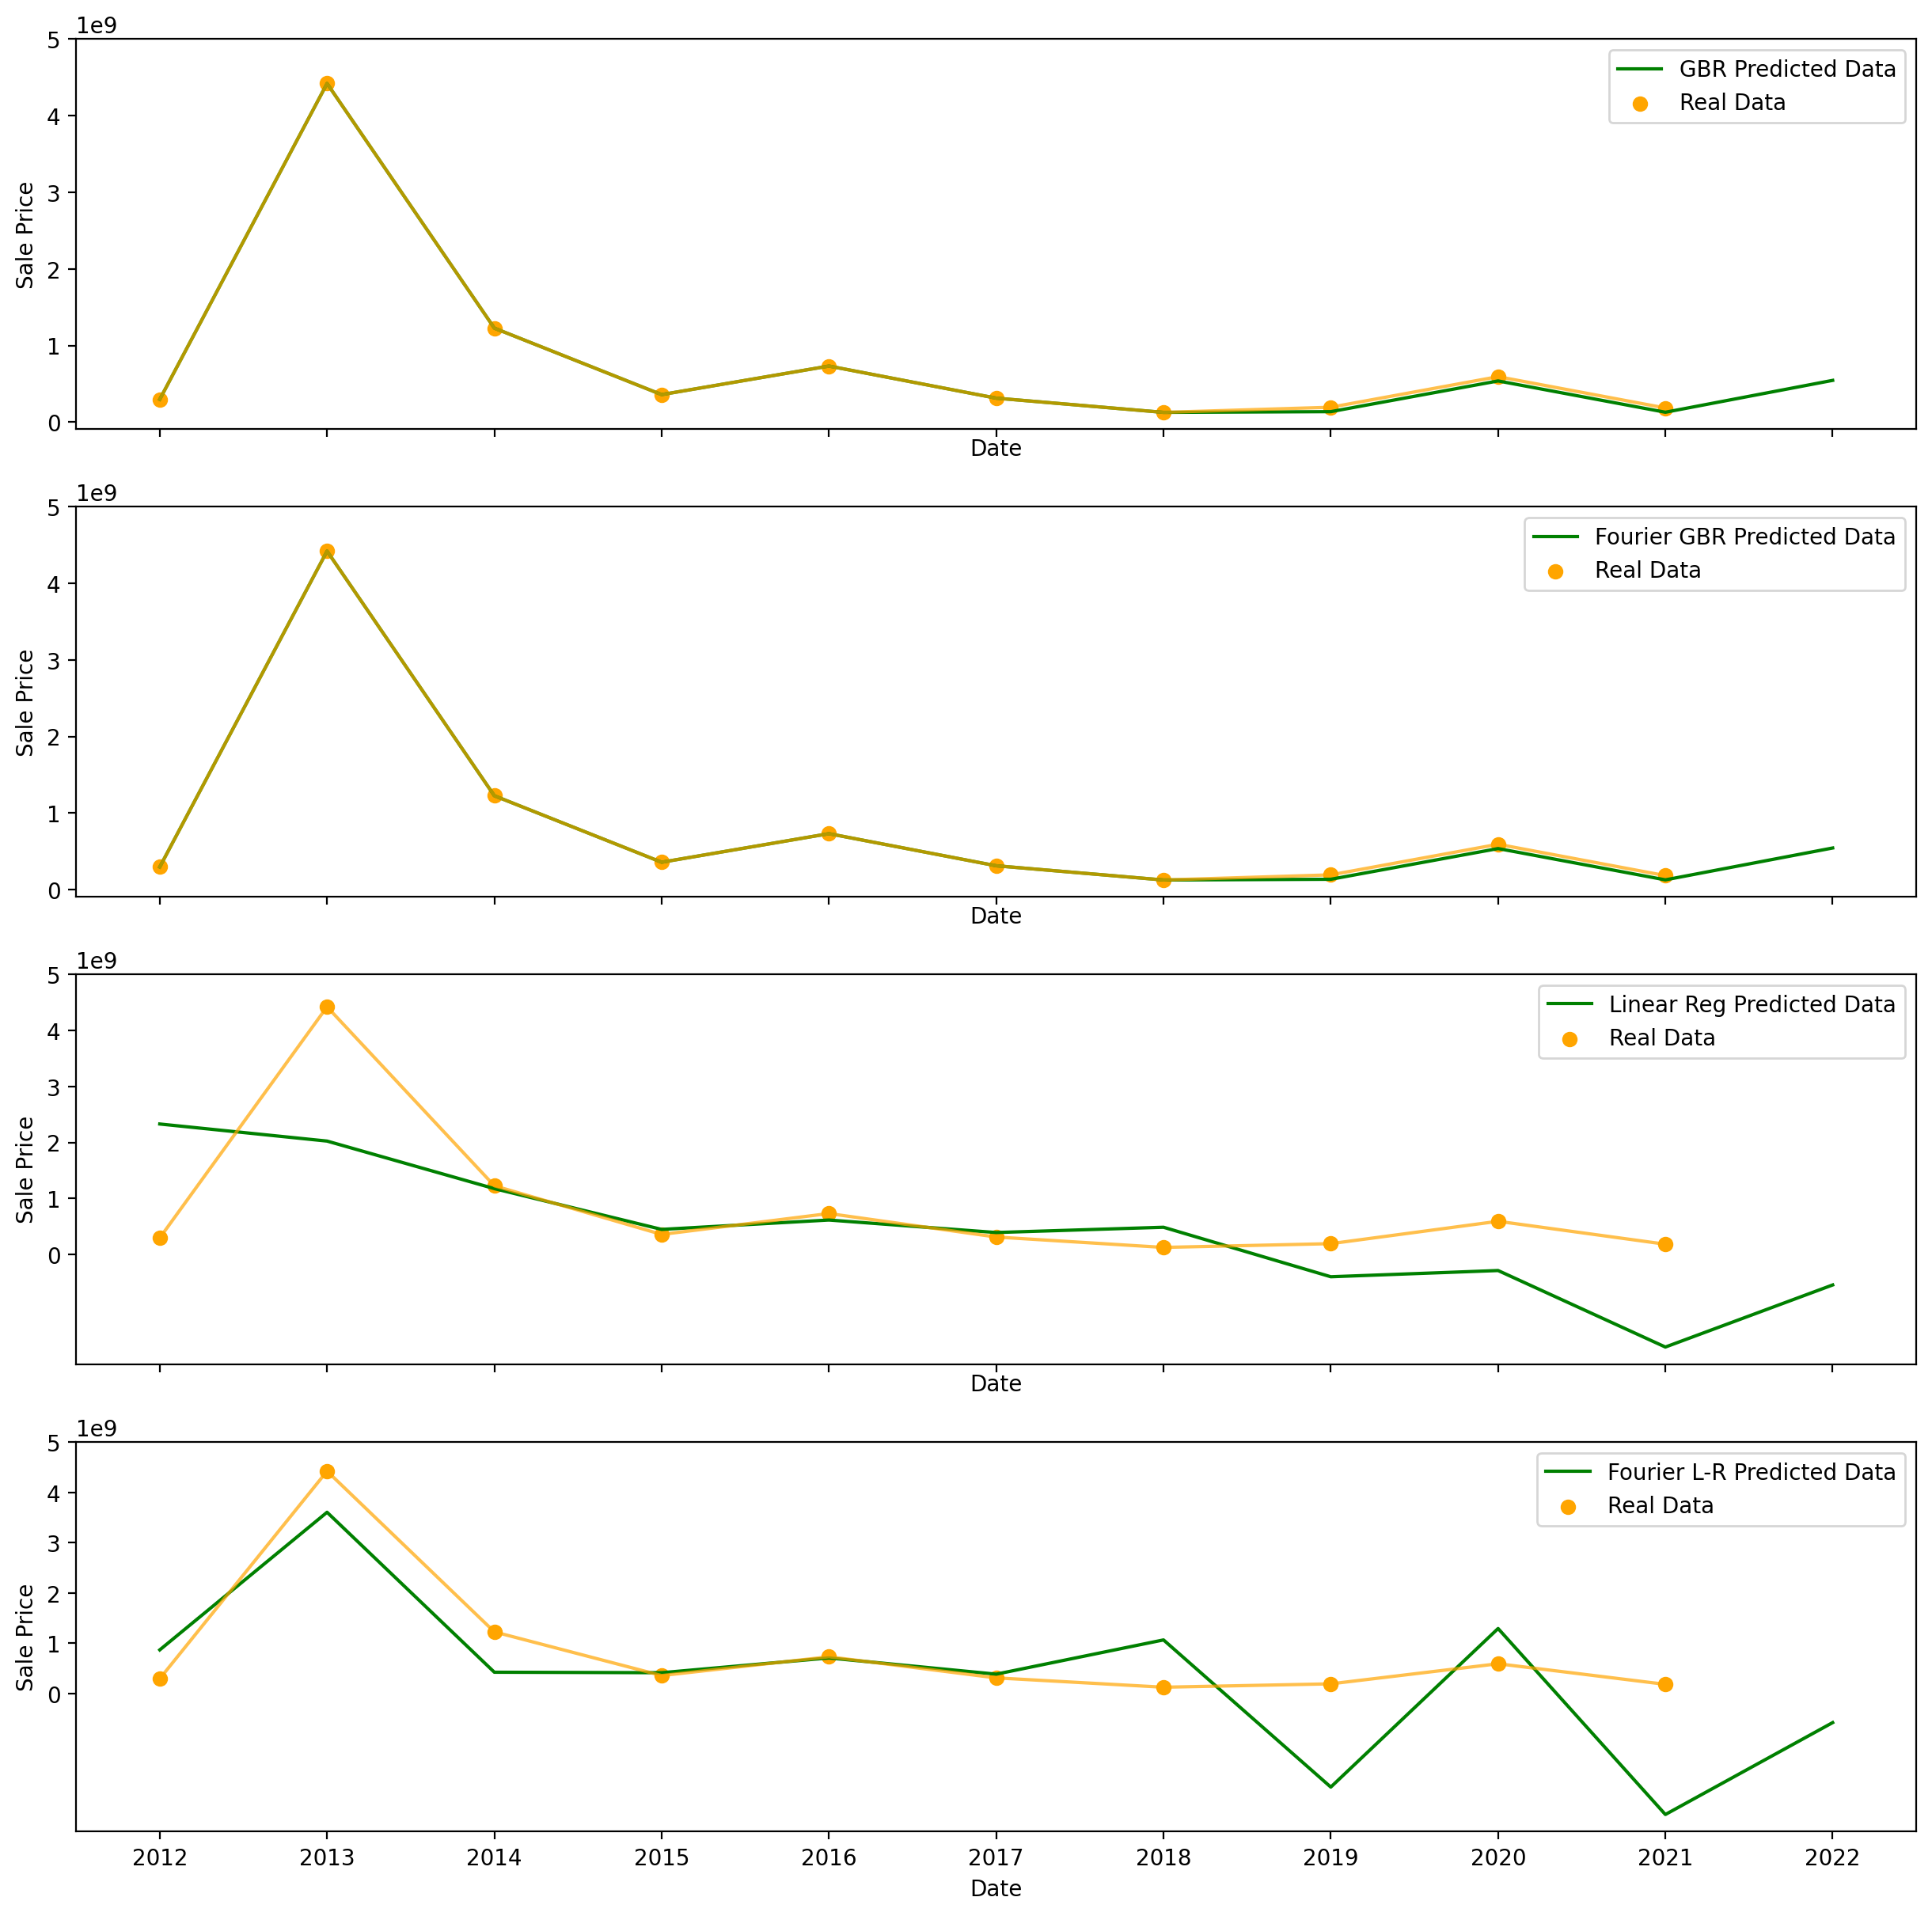

In [440]:
y = predictionLr
y = mmscaler.inverse_transform(y.reshape(-1, 1))
y1 = df10[['ss']] #mmscaler.inverse_transform(df3[['ss']])
y2 = reg.predict(np.concatenate([X_train, X_test]))
y2 = mmscaler.inverse_transform(y2.reshape(-1, 1))
y3 = model.predict(X_train_test_poly)
y3 = mmscaler.inverse_transform(y3.reshape(-1, 1))
y4 = predictionGbr
y4 = mmscaler.inverse_transform(y4.reshape(-1, 1))


plt.clf()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1,figsize=(15,15) , sharex=True)
fig.dpi = 200

ax1.plot(df10.dd, y2.ravel(), color="green", label="GBR Predicted Data")
ax1.plot(df10.dd, y1, alpha=0.7, color="orange")
ax1.scatter(df10.dd, y1, color="orange", label="Real Data")
ax1.set_yticks(np.arange(0, 6e9, 1e9))
ax1.set_xticks(np.arange(2012, 2023, 1))
ax1.set_ylabel("Sale Price")
ax1.set_xlabel("Date")
ax1.legend(loc="upper right")

ax2.plot(df10.dd, y4.ravel(), color="green", label="Fourier GBR Predicted Data")
ax2.plot(df10.dd, y1, alpha=0.7, color="orange")
ax2.scatter(df10.dd, y1, color="orange", label="Real Data")
ax2.set_yticks(np.arange(0, 6e9, 1e9))
ax2.set_xticks(np.arange(2012, 2023, 1))
ax2.set_ylabel("Sale Price")
ax2.set_xlabel("Date")
ax2.legend(loc="upper right")

ax3.plot(df10.dd, y3.ravel(), color="green", label="Linear Reg Predicted Data")
ax3.plot(df10.dd, y1, alpha=0.7, color="orange")
ax3.scatter(df10.dd, y1, color="orange", label="Real Data")
ax3.set_yticks(np.arange(0, 6e9, 1e9))
ax3.set_xticks(np.arange(2012, 2023, 1))
ax3.set_ylabel("Sale Price")
ax3.set_xlabel("Date")
ax3.legend(loc="upper right")



ax4.plot(df10.dd, y.ravel(), color="green", label="Fourier L-R Predicted Data")
ax4.plot(df10.dd, y1, alpha=0.7, color="orange")
ax4.scatter(df10.dd, y1, color="orange", label="Real Data")
ax4.set_yticks(np.arange(0, 6e9, 1e9))
ax4.set_xticks(np.arange(2012, 2023, 1))
ax4.set_ylabel("Sale Price")
ax4.set_xlabel("Date")
ax4.legend(loc="upper right")
plt.savefig("./Prediction.png")
plt.show()
plt.close(fig)